In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
# tai from ... import *

# Dataframe haku widgeteillä

In [2]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

In [2]:
df = database_query("SELECT * FROM SensorData limit 100000")
df.head(5)

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Kun haku on valmis niin dataframe tallenttuu df:ään

# Dataframe suodattaminen widgeteillä

In [3]:
#display(start_date, end_date, tunnit)
display(tunnit)

SelectionRangeSlider(description='Tunnit', index=(0, 14), options=(8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

In [17]:
# Kutstutaan sort_by_widgets ja boom dataframessa on ainoastaan 11-19 tunnit
df1 = sort_by_widgets(df)
df1.head()

TypeError: '>=' not supported between instances of 'bytes' and 'Timestamp'

# Horrostilat dataframeen

In [18]:
df1 = horrostila(df1)
df1

,node_id,timestamp,x,y,x_grid,y_grid,grid_id,IN,OUT,fo_IN,fo_OUT,Horrostila
0,1,2020-06-24 15:20:08.533,2762,-257,27,12,507,False,False,NaN,NaN,False
1,1,2020-06-24 15:20:08.620,2870,-344,28,11,468,True,False,NaN,NaN,False
2,1,2020-06-24 15:20:09.623,2916,-344,29,11,469,True,False,NaN,NaN,False
3,1,2020-06-24 15:20:09.623,2894,-254,28,12,508,True,False,NaN,NaN,False
4,1,2020-06-24 15:20:10.116,2888,-188,28,12,508,True,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
94789,1,2020-07-18 12:53:05.795,2952,1060,29,22,909,False,False,False,False,False
94790,1,2020-07-18 12:53:05.795,2962,1046,29,22,909,False,False,False,False,False
94791,1,2020-07-18 12:53:06.795,2969,1040,29,22,909,False,False,False,False,False
94792,1,2020-07-18 12:53:07.795,2982,1037,29,22,909,False,False,False,False,False


Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 4041
uniques in y 4035
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  100000
Ouliers removed:     173
Data after:  99827


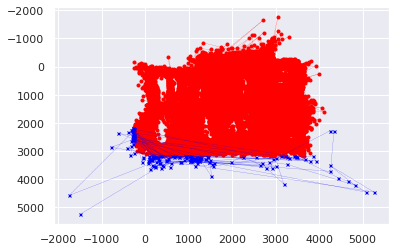

In [3]:
df1 = find_outliers(df)

In [4]:
df1 = clean_dataframe(df1)
df1.head(5)

,node_id,timestamp,x,y,dayofweek,current_hour
0,1,2020-06-24 15:20:08.533,2762,-257,2,8
1,1,2020-06-24 15:20:08.620,2870,-344,2,8
2,1,2020-06-24 15:20:09.623,2916,-344,2,8
3,1,2020-06-24 15:20:09.623,2894,-254,2,8
4,1,2020-06-24 15:20:10.116,2888,-188,2,8


## Piirretään horrostilat

In [ ]:
draw_horrostilat(df1, 'x', 'y')

# Piirretään nodejen käyttömäärä

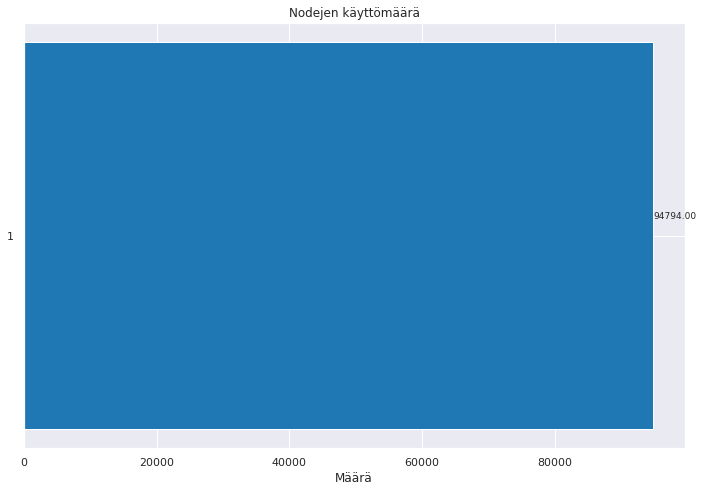

In [21]:
draw_node_amount(df1, 'node_id')

In [5]:
grid_size = 40
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
df1

,node_id,timestamp,x,y,dayofweek,current_hour,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.533,2762,-257,2,8,27,12,507
1,1,2020-06-24 15:20:08.620,2870,-344,2,8,28,11,468
2,1,2020-06-24 15:20:09.623,2916,-344,2,8,29,11,469
3,1,2020-06-24 15:20:09.623,2894,-254,2,8,28,12,508
4,1,2020-06-24 15:20:10.116,2888,-188,2,8,28,12,508
...,...,...,...,...,...,...,...,...,...
94789,1,2020-07-18 12:53:05.795,2952,1060,5,5,29,22,909
94790,1,2020-07-18 12:53:05.795,2962,1046,5,5,29,22,909
94791,1,2020-07-18 12:53:06.795,2969,1040,5,5,29,22,909
94792,1,2020-07-18 12:53:07.795,2982,1037,5,5,29,22,909


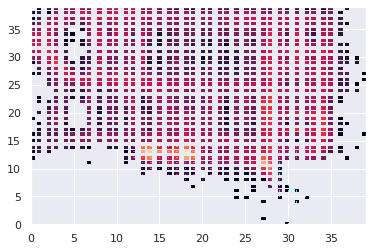

In [6]:
in_x, in_y = sisään(df1, 'x_grid', 'y_grid')
out_x, out_y = ulos(df1, 'x_grid', 'y_grid')

draw_exits(df1, in_x, in_y, out_x, out_y, 'x_grid', 'y_grid')

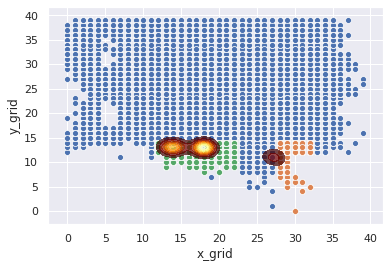

In [7]:
 # Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()

In [8]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df_reitit = reitit_dataframeksi(reitit)

In [ ]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

In [9]:
aloitukset, lapimenoajat = get_lapimeno(reitit, grid_size)

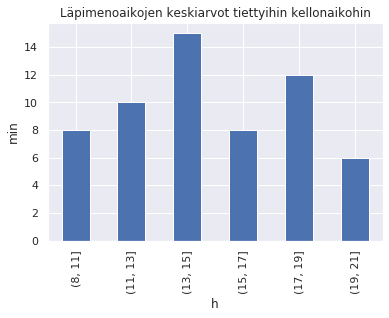

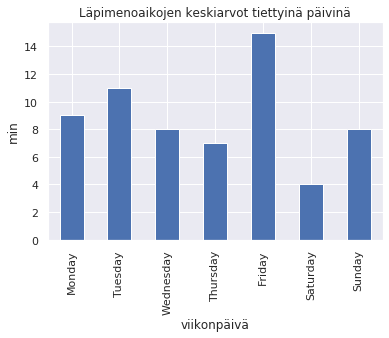

In [10]:
plot_lapimeno(aloitukset, lapimenoajat)

In [11]:
df_reitit['kesto']=df_reitit['kesto'].dt.total_seconds()

,ajokerta,node_id,timestamp,x,y,grid_id,kesto
0,1,1,2020-06-24 15:20:12.995,29,14,589,64857.237
1,1,1,2020-06-24 15:20:13.596,29,14,589,64857.237
2,1,1,2020-06-24 15:20:14.482,30,14,590,64857.237
3,1,1,2020-06-24 15:20:15.659,31,13,551,64857.237
4,1,1,2020-06-24 15:20:15.837,31,13,551,64857.237
...,...,...,...,...,...,...,...
374,97,1,2020-07-18 12:04:39.795,18,13,538,739.998
375,97,1,2020-07-18 12:04:40.795,18,13,538,739.998
376,97,1,2020-07-18 12:04:42.793,18,13,538,739.998
377,97,1,2020-07-18 12:04:51.793,18,13,538,739.998
